# CV 2021 HW2-3 Colorizing Russian Empire

## Introduction
- In this section, we need to write a script that **automatically** produce color images from the digitalized [Prokudin- Gorskii glass plate images](http://www.cs.cmu.edu/afs/cs.cmu.edu/academic/class/15463-s10/www/proj1/www/abarnat/images/standard/)
- We are asked to assume that **only x, y translation are needed** to align different color channels of the images, which turns out to be insufficient for aligning large images (discussed at last part).
- We implement a two-stage alignment process based on [Canny edge detector](https://en.wikipedia.org/wiki/Canny_edge_detector), our method is highly efficiant because we only correlate between binary edge images.
- For large images of size (MxN), edge detecting and correlating becomes computationaly expansive. We avoid this problem by first resizeing the input images to (300x300), we then find  x, y translation for aligning these smaller images. Finally, to align the large images of original size, we scaled the previous translation by the resizing ratio
 
 $$X_{original} = {x_{resized} \times \lfloor{ M \over 300 }\rfloor} $$
 $$Y_{original} = {y_{resized} \times \lfloor{ N \over 300 }\rfloor} $$
 
- While the resizing mechanism speeds things up, it fails to align the original images accurately due to the rounding effect of scaling the translation. To solve this, we crop a small region of the previous aligned image, and **do the alignment process on the small region again**. The resulting $X_{correction} , Y_{correction}$ translation of the small region is then applied to the whole image to yeild result of higher quality. 

## Settings
- `image_file` input image location
- `plot_log=True` plot intermediate result
- `save_intermediate` save real-size image after first alignment
- `save_final` save real-size image after secong alignment


In [10]:
image_file = 'hw2_data/task3_colorizing/emir.tif'
plot_log = True
save_intermediate = True
save_final = True

#---------------------------
filename, filetype = image_file.split('.')

## Step 0 
- Read input image channels from file. 
    
    `r,g,b` variables store the real-size (`M`x`N`) image channels.
- Resize each image to (300x300).

    `rr,gg,bb` variables store the resized image channels.
- Apply *Canny edge dection* on each channel.

    `rre, gge, bbe` variables store the edge of resized image channels.

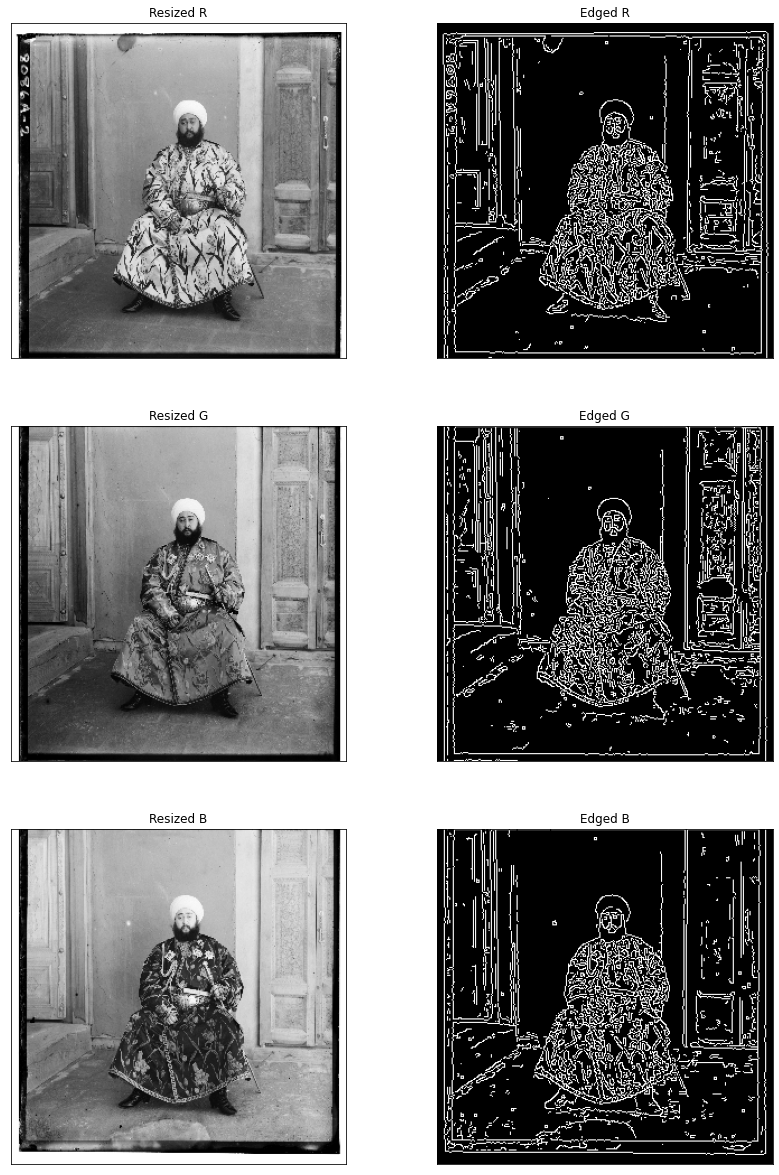

In [11]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.patches as patches

img = cv2.imread(image_file,0)

M,N = img.shape
r,g,b = img[0:M//3,:], img[M//3:M//3*2,:] , img[M//3*2:M//3*3,:]

rr = cv2.resize(r,(300,300))
gg = cv2.resize(g,(300,300))
bb = cv2.resize(b,(300,300))

rre = cv2.Canny(rr,100,150)
gge = cv2.Canny(gg,100,150)
bbe = cv2.Canny(bb,100,150)

#plot the result
if plot_log:
    f = plt.figure(figsize=(14,21))
    plt.subplot(321),plt.imshow(rr,cmap = 'gray'),plt.title('Resized R'), plt.xticks([]), plt.yticks([])
    plt.subplot(322),plt.imshow(rre,cmap = 'gray'),plt.title('Edged R'), plt.xticks([]), plt.yticks([])
    plt.subplot(323),plt.imshow(gg,cmap = 'gray'),plt.title('Resized G'), plt.xticks([]), plt.yticks([])
    plt.subplot(324),plt.imshow(gge,cmap = 'gray'),plt.title('Edged G'), plt.xticks([]), plt.yticks([])
    plt.subplot(325),plt.imshow(bb,cmap = 'gray'),plt.title('Resized B'), plt.xticks([]), plt.yticks([])
    plt.subplot(326),plt.imshow(bbe,cmap = 'gray'),plt.title('Edged B'), plt.xticks([]), plt.yticks([])
    plt.show()

## Step1 (align small image)
### Shift and correlate the Canny edge images to find the aligning offset. 

-   This process is implemented in **`find_offset`** function, which correlates 2 binary edge images, by summation after elemenwise `bitwise_and`.

    
    **Function input:**
    
    > 1. `e1`: image1
    > 2. `e2`: image2
    > 3. `x_range`: translation search range (from `-x_range` to `x_range`) in x direction
    > 4. `y_range`: translation search range (from `-y_range` to `y_range`) in y direction
    
    **Funciton output:**
    > `(x,y)` : the best translation offset in both axis
The 

### Apply the offset to the resized-image and edge-images to see the aligning effect.
    
    
-   This process in implemented in **align** function.

       
    **Function input:**   
    > 1. `img1`: image of channel 1
    > 2. `img2`: image of channel 2
    > 3. `img3`: image of channel 3
    > 4. `offset_21`: translation offset between img2 and img1
    > 5. `offset_23`: translation offset between img2 and img3
    
    **Funciton output:**
    >  `result ` resulting image with 3 channels  
    
Note that both `find_offset` and `align` can be used on images of any size, they will be reused several times in latter stages.


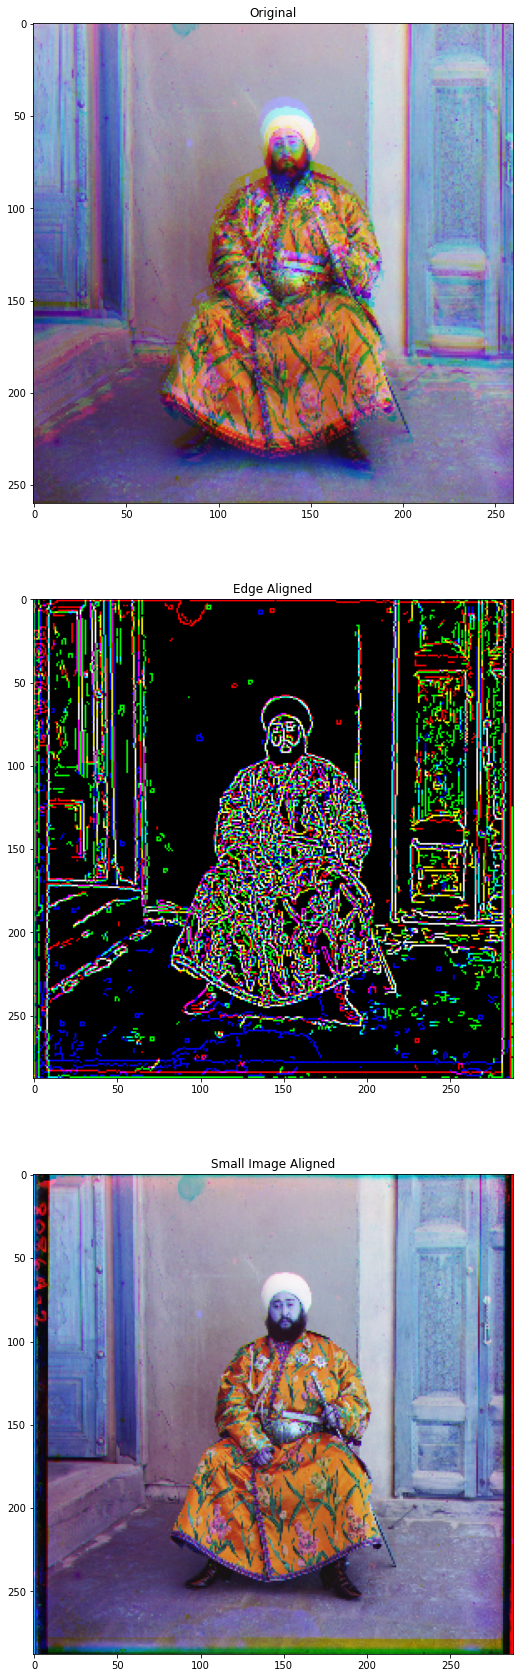

In [12]:
# crop_width
c = 20

# find the shifting offset given two binary edge image  
def find_offset(e1,e2,x_range, y_range):
    "align the two binary images"
    assert e1.shape == e2.shape
    M,N = e2.shape
    best_score = 0
    best_offset = None
    patch1 = e1[x_range:-x_range,y_range:-y_range]
    for i in range(-x_range,x_range):
        for j in range(-y_range,y_range):
            patch2 = e2[i+x_range:i-x_range,j+y_range:j-y_range]
            current_score = np.sum( np.bitwise_and(patch1, patch2) )
            if current_score > best_score:
                best_score = current_score
                best_offset = (i,j)
    return best_offset 

# align 3 image channels given shifting offset
def align(img1,img2,img3, offset21, offset23):
    x21,y21 = offset21
    x23,y23 = offset23
    c =  max(np.abs([x21, x23, y21, y23]))+1
    result = np.stack([img1[c+x21:-c+x21,c+y21:-c+y21],
                       img2[c:-c,c:-c],
                       img3[c+x23:-c+x23,c+y23:-c+y23]],axis=2)
    return result

gr = find_offset(gge[c:-c,c:-c]//255,rre[c:-c,c:-c]//255,30,30)
gb = find_offset(gge[c:-c,c:-c]//255,bbe[c:-c,c:-c]//255,30,30)
aligned_edge = align(rre,gge,bbe,gr,gb)

if plot_log:
    aligned = align(rr,gg,bb,gr,gb)

    f = plt.figure(figsize=(15,30))
    plt.subplot(311),plt.imshow(np.stack([rr,gg,bb],axis=2)[c:-c,c:-c]),plt.title('Original')#, plt.xticks([]), plt.yticks([])
    plt.subplot(312),plt.imshow(aligned_edge),plt.title('Edge Aligned')#, plt.xticks([]), plt.yticks([])
    #plt.subplot(313),plt.imshow(cv2.normalize(aligned,aligned,255,0,norm_type=cv2.NORM_MINMAX)),plt.title('Aligned'), plt.xticks([]), plt.yticks([])
    plt.subplot(313),plt.imshow(aligned),plt.title('Small Image Aligned')#, plt.xticks([]), plt.yticks([])
    plt.plot()


## Step2  ( scale the offset and align real-size image)
- Scale the translating offsets found in the previous step and apply the result to real-size images

> `gr_real` is the scaled offset from `gr`

> `gb_real` is the scaled offset from `gb`

- Save the result if specified.

- If we plot the **Zoomed Detail** of the real-size aligned images, we might see small defect cause by the scaling process. 

1604 1851


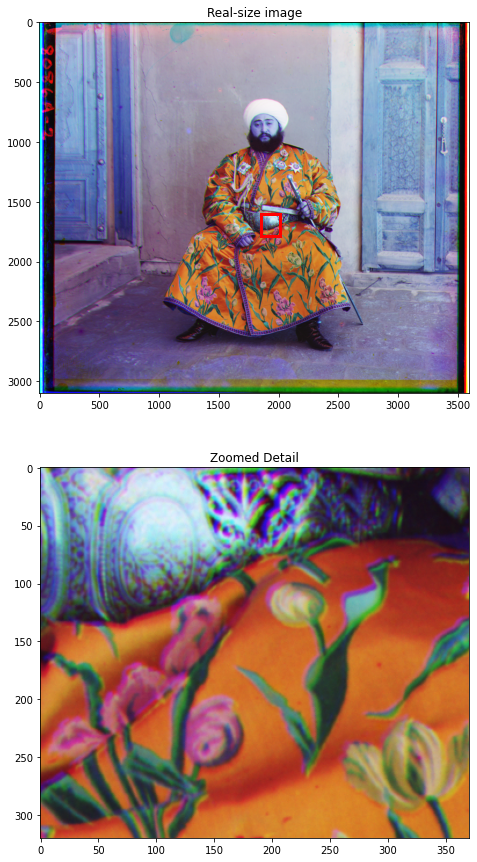

In [13]:
# scale the offset
gr_real = (int(np.round((M//3)/300 * gr[0])), int(np.round(N/300 * gr[1])))
gb_real = (int(np.round((M//3)/300 * gb[0])), int(np.round(N/300 * gb[1])))
# apply offset to real size images
aligned_real = align(r,g,b,gr_real,gb_real)

#save file
if save_intermediate:
    cv2.imwrite(filename+'_intermediate'+'.'+filetype,aligned_real)

if plot_log:
    plt.figure(figsize=(10,15))
    ax = plt.subplot(211)
    ax.imshow(aligned_real)
    ax.set_title('Real-size image')
    #x_rand,y_rand=np.random.randint(low=M//30*2,high=M//3-M//30*2), np.random.randint(low=N//10*2,high=N-N//10*2)
    x_rand,y_rand = M//6,N//2
    rect = patches.Rectangle((y_rand,x_rand),M//60,N//20, linewidth=3, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
    ax = plt.subplot(212)
    ax.set_title('Zoomed Detail')

    print(x_rand,y_rand)
    plt.imshow(aligned_real[x_rand:x_rand+ M//30,y_rand:y_rand+ N//10])
    plt.plot()

## Step3 (Choose edge-rich rect region for error correction)
- For small-sized images we already get satisfying result, this and the following steps are optional.
- For large image, we first find a small rectangular region that contains resonable amount of edges 

    This process is implemented in `find_edge_region` function, 
    where we seperate the small-edge images in to 10x10 tiny rect regions,
    and then iterate through each region, find the one that contains the most **"edge aligning information"**  
    > The metric used here to evaluate the amount of "aligning information" is as follows: 
    > 
    $$ Edge\_Score = \Sigma_{all\_pixels}  [ \mathtt{bitwise\_and (re, ge, be)} + \mathtt{re} + \mathtt{ge} + \mathtt{be} ]  $$
    >
    > where `re`, `ge`, `be` are the Canny Edge of each channel of aligned small image
    
    > `bitwise_and` find those pixel where edges are presented in all 3 channel (great alignment)
    


busy region: (5, 6)


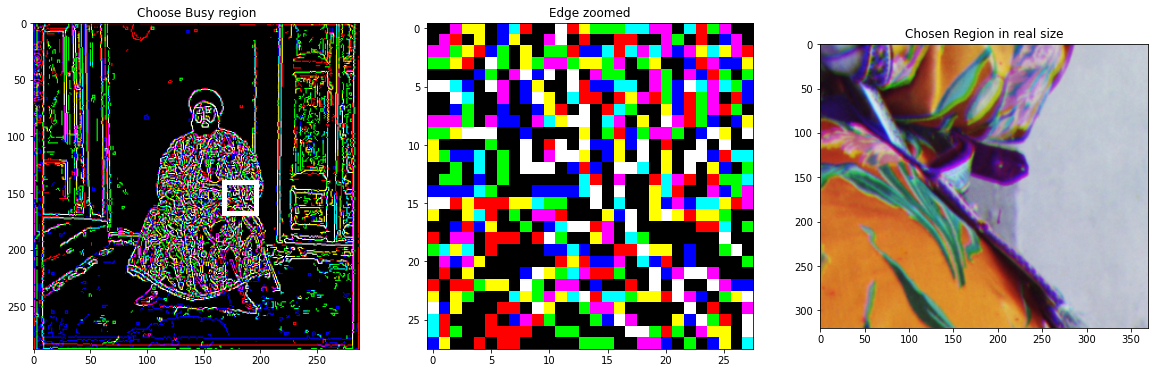

In [14]:
#Further Enhencement

# find complex location in small image
def find_edge_region(re,ge,be):
    """ Given binary canny edges as input, output the coordinate of the top-left corner of a busy region
        The coordinate is normalized to the range (0,10)x(0,10)
    """
    assert re.shape == ge.shape and re.shape == be.shape
    m,n = re.shape
    s = m//10
    best_score = 0
    best_region = None
    for i in range(2,8):
        for j in range(2,8):
            re_patch = re[i*s:(i+1)*s,j*s:(j+1)*s]
            ge_patch = ge[i*s:(i+1)*s,j*s:(j+1)*s]
            be_patch = be[i*s:(i+1)*s,j*s:(j+1)*s]
            matching_score =  np.sum(np.bitwise_and(np.bitwise_and(re_patch,ge_patch),be_patch))
            edge_amount = np.sum(re_patch) + np.sum(ge_patch) + np.sum(be_patch)
            current_score = matching_score + edge_amount
            if current_score > best_score:
                best_score = current_score
                best_region = (i,j)
    return best_region

er = find_edge_region(*[aligned_edge[:,:,i]//255 for i in range(3)])
print(f'busy region: {er}')

if plot_log: 
    fig,ax = plt.subplots(1,3,figsize=(20,6))
    ax[0].imshow(aligned_edge)
    ax[0].set_title('Choose Busy region')
    x,y = aligned_edge.shape[0]//10, aligned_edge.shape[1]//10
    X,Y = M//30, N//10
    rect = patches.Rectangle((x*er[1],y*er[0]),x,y, linewidth=5, edgecolor='w', facecolor='none')
    ax[0].add_patch(rect)
    ax[1].set_title('Edge zoomed')
    ax[1].imshow(aligned_edge[x*er[0]:x*er[0]+x, y*er[1]:y*er[1]+y])
    ax[2].set_title('Chosen Region in real size')
    ax[2].imshow(aligned_real[X*er[0]:X*er[0]+X, Y*er[1]:Y*er[1]+Y])
    plt.show()

## Step4 (Alignment for the 2'nd time)
- After finding a region, we repeat the process of `find_offset` on that small region of real size image,
    and then apply the $X_{correction}$ , $Y_{correction}$ offsets to the whole real size image.
- In the code below, `re`, `ge`, `be` store the Canny edges of the croped rectangular edge-rich region that we chose in the previous step

   `gr2` and `gb2` stors the offset information for the second alignment process

offset gr=(-3, 0), offset gb = (-4, -4)


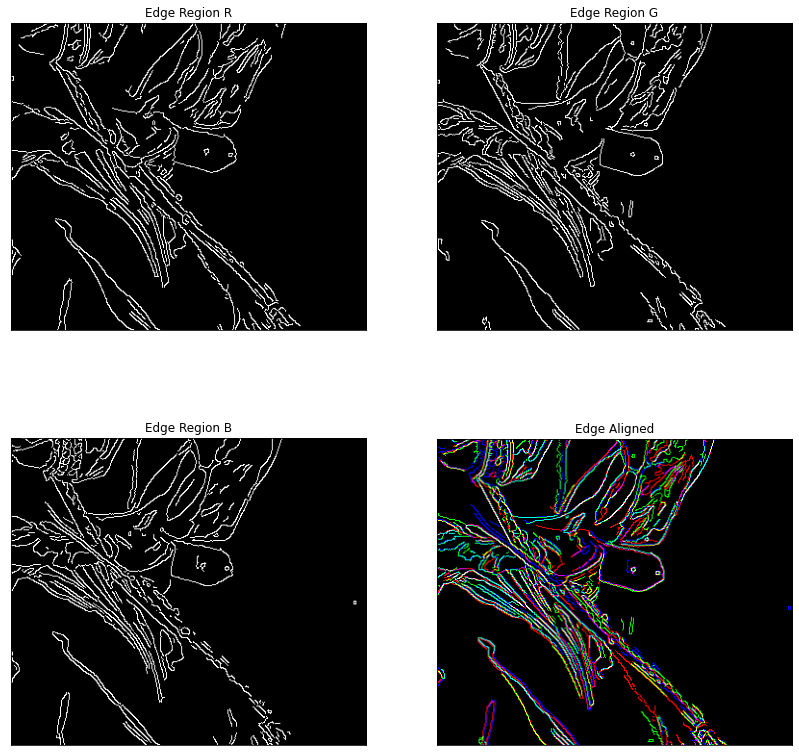

In [15]:
# crop the edge region from aligned real size image 
edge_region = aligned_real[ X*er[0]:X*er[0] +X , Y*er[1]:Y*er[1]+Y, : ]
# find edge using Canny
re = cv2.Canny(edge_region[:,:,0],100,150)
ge = cv2.Canny(edge_region[:,:,1],100,150)
be = cv2.Canny(edge_region[:,:,2],100,150)

# find offset for the second alignment process
gr2 = find_offset(ge//255,re//255,X//10,Y//10)
gb2 = find_offset(ge//255,be//255,X//10,Y//10)
print(f'offset gr={gr2}, offset gb = {gb2}')

# final result
aligned_real2 = align(*[aligned_real[:,:,i] for i in range(3)],gr2,gb2)

if save_final:
    cv2.imwrite(filename+'_final.'+filetype,aligned_real2)

if plot_log:
    aligned_edge2 = align(re,ge,be,gr2,gb2)
    f = plt.figure(figsize=(14,14))
    plt.subplot(221),plt.imshow(re,cmap = 'gray'),plt.title('Edge Region R'), plt.xticks([]), plt.yticks([])
    plt.subplot(222),plt.imshow(ge,cmap = 'gray'),plt.title('Edge Region G'), plt.xticks([]), plt.yticks([])
    plt.subplot(223),plt.imshow(be,cmap = 'gray'),plt.title('Edge Region B'), plt.xticks([]), plt.yticks([])
    plt.subplot(224),plt.imshow(aligned_edge2),plt.title('Edge Aligned'), plt.xticks([]), plt.yticks([])

    plt.show()

## Result Comparason

- If we **Zoom In** the real-size image, we can see that the result after Second Alignment is much better in the Target Region (ie, edge-rich rect we chose).
- However, even if we align perfectly in the chosen small region, other region may still encounter serious shifting phenomenon, this implys that the channels in the original image are **not only shifted, but also distorted**, hence it is impossible to get perfect alignment in all the region if we only consider translation.

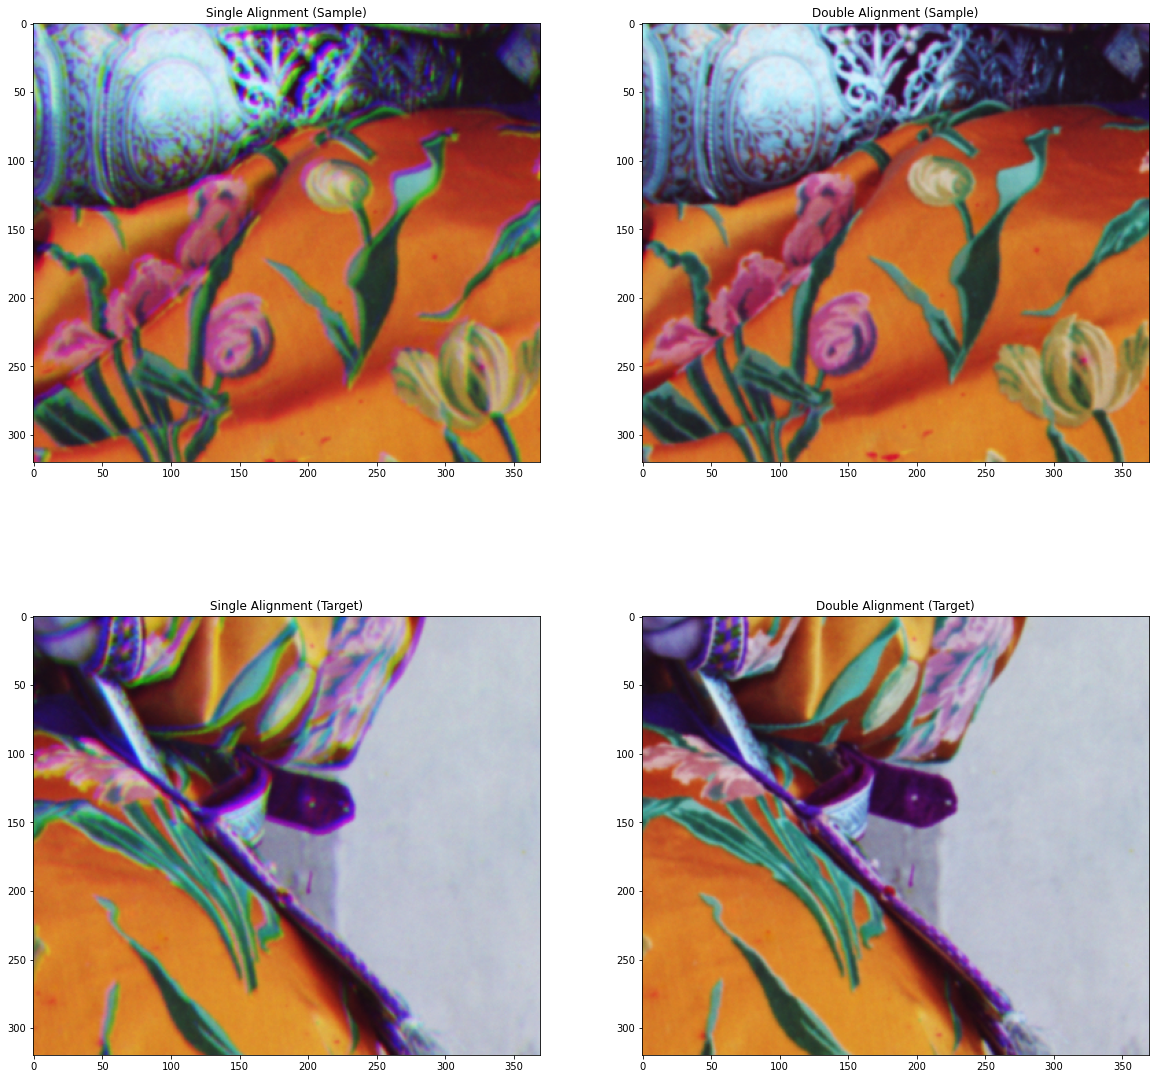

In [16]:
if plot_log: 
    f,ax = plt.subplots(2,2,figsize=(20,20))
    ax[0][0].imshow(aligned_real[x_rand:x_rand+ X,y_rand:y_rand+ Y])
    ax[0][0].set_title('Single Alignment (Sample)')
    ax[0][1].imshow(aligned_real2[x_rand:x_rand+ X,y_rand:y_rand+ Y])
    ax[0][1].set_title('Double Alignment (Sample)')
    ax[1][0].imshow(aligned_real[X*er[0]:X*er[0]+X, Y*er[1]:Y*er[1]+Y])
    ax[1][0].set_title('Single Alignment (Target)')
    ax[1][1].imshow(aligned_real2[X*er[0]:X*er[0]+X,Y*er[1]:Y*er[1]+Y])
    ax[1][1].set_title('Double Alignment (Target)')
    plt.show()